# Construction of Route Graphs

In [1]:
import json
import time
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import isodate
import cvxpy as cp
import gurobipy
from functools import reduce

### Load Json

In [104]:
scenario = "01_dummy.json"  # adjust path to the sample instance if it is not located there
with open(scenario) as fp:
    scenario = json.load(fp)

### Process section requirements

In [105]:
service_intentions = {}
for si in scenario['service_intentions']:
    requirements = {}
    for i,req in enumerate(si['section_requirements']):
        requirements[req['section_marker']] = {key:value for key,value in req.items()}
        if i == 0:
            requirements[req['section_marker']]['start_end'] = 'start'
        elif i == len(si['section_requirements']) - 1:
            requirements[req['section_marker']]['start_end'] = 'end'
        else: 
            requirements[req['section_marker']]['start_end'] = None
    service_intentions[si['id']] = requirements

#get resources
resources = {}
for resource in scenario['resources']:
    idx = resource['id']
    if idx in resources:
        print('something is wrong')
    resources[idx] = resource['release_time']

### Printing of nodes

In [106]:
def from_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_entry" in route_section.keys() and \
            route_section["route_alternative_marker_at_entry"] is not None and \
            len(route_section["route_alternative_marker_at_entry"]) > 0:
                return "(" + str(route_section["route_alternative_marker_at_entry"][0]) + ")"
    else:
        if index_in_path == 0:  # can only get here if this node is a very beginning of a route
            return "(" + str(route_section["sequence_number"]) + "_beginning)"
        else:
            return "(" + (str(route_path["route_sections"][index_in_path - 1]["sequence_number"]) + "->" +
                          str(route_section["sequence_number"])) + ")"
def to_node_id(route_path, route_section, index_in_path):
    if "route_alternative_marker_at_exit" in route_section.keys() and \
            route_section["route_alternative_marker_at_exit"] is not None and \
            len(route_section["route_alternative_marker_at_exit"]) > 0:

                return "(" + str(route_section["route_alternative_marker_at_exit"][0]) + ")"
    else:
        if index_in_path == (len(route_path["route_sections"]) - 1): # meaning this node is a very end of a route
            return "(" + str(route_section["sequence_number"]) + "_end" + ")"
        else:
            return "(" + (str(route_section["sequence_number"]) + "->" +
                          str(route_path["route_sections"][index_in_path + 1]["sequence_number"])) + ")"

### Construct graph for every SI, and appropriate edge constraints

In [107]:
route_section_keys = ['penalty', 'minimum_running_time']
section_requirement_keys = ['start_end','min_stopping_time', 'entry_earliest', 'entry_latest',
                           'exit_earliest', 'exit_latest', 'entry_delay_weight',
                           'exit_delay_weight']

In [108]:
start_time = time.time()

# now build the graph. Nodes are called "previous_FAB -> next_FAB" within lineare abschnittsfolgen and "AK" if
# there is an Abschnittskennzeichen 'AK' on it
route_graphs = dict()
for route in scenario["routes"]:# iterates over si?
    
    print(f"\nConstructing route graph for route {route['id']}")
    # set global graph settings
    G = nx.DiGraph(route_id = route["id"], name="Route-Graph for route "+str(route["id"]))

    # add edges with data contained in the preprocessed graph
    for path in route["route_paths"]:#iterate over admissible routes
        print('new route')
        for (i, route_section) in enumerate(path["route_sections"]):
            sn = route_section['sequence_number']
            print("Adding Edge from {} to {} with sequence number {}".format(from_node_id(path, route_section, i), to_node_id(path, route_section, i), sn))
            edge_data = {}
            for key in route_section_keys:
                if key in route_section:
                    edge_data[key] = route_section[key]
                else:
                    edge_data[key] = None
                
            if 'resource_occupations' in route_section:
                resource_occupations = {}
                for resource in route_section['resource_occupations']:
                    idx = resource['resource']
                    R = resources[idx]
                    resource_occupations[idx] = R
                    #maximum? code below
                    R=[isodate.parse_duration(value).seconds for key,value in resource_occupations.items()]
            edge_data['resource_occupations'] = resource_occupations
            edge_data['R'] = max(R)
            
            #get section marker
            section_marker = None
            if 'section_marker' in route_section:
                try:
                    section_marker = route_section['section_marker'][0]
                except:
                    pass
            edge_data['section_marker'] = section_marker
            
            
            
            if section_marker in service_intentions[route['id']]:
                for key in section_requirement_keys:
                    if key in service_intentions[route['id']][section_marker]:
                            edge_data[key] = service_intentions[route['id']][section_marker][key]
        
            edge_data['sequence_number'] = sn
            
            print(edge_data)
            G.add_edge(from_node_id(path, route_section, i),
                       to_node_id(path, route_section, i),
                       edge_data = edge_data)

    route_graphs[route["id"]] = G

print("Finished building fahrweg-graphen in {} seconds".format(str(time.time() - start_time)))


Constructing route graph for route 18823
new route
Adding Edge from (TW4) to (500->501) with sequence number 500
{'penalty': 0.1, 'minimum_running_time': 'PT1M10S', 'resource_occupations': {'RUES_61': 'PT10S', 'RUES_71': 'PT10S', 'TW_23': 'PT10S', 'TW_33': 'PT10S', 'TW_4': 'PT10S'}, 'R': 10, 'section_marker': '', 'sequence_number': 500}
Adding Edge from (500->501) to (501->502) with sequence number 501
{'penalty': None, 'minimum_running_time': 'PT16S', 'resource_occupations': {'RUES_71': 'PT10S', 'TW_23': 'PT10S', 'TW_33': 'PT10S', 'TW_4': 'PT10S'}, 'R': 10, 'section_marker': '', 'sequence_number': 501}
Adding Edge from (501->502) to (502->503) with sequence number 502
{'penalty': None, 'minimum_running_time': 'PT6S', 'resource_occupations': {'TW_23': 'PT10S', 'TW_33': 'PT10S', 'TW_4': 'PT10S'}, 'R': 10, 'section_marker': '', 'sequence_number': 502}
Adding Edge from (502->503) to (503->504) with sequence number 503
{'penalty': None, 'minimum_running_time': 'PT19S', 'resource_occupatio

### Draw Graphs

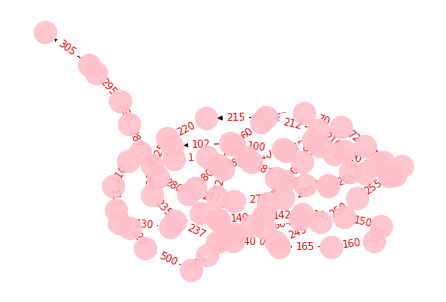

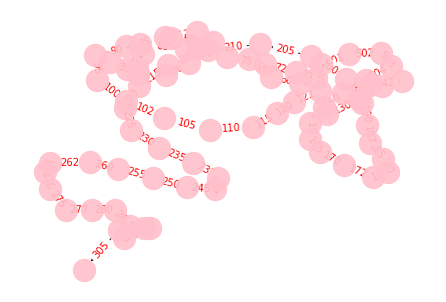

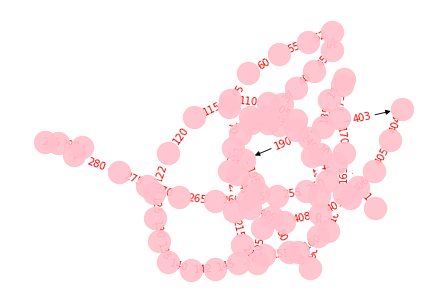

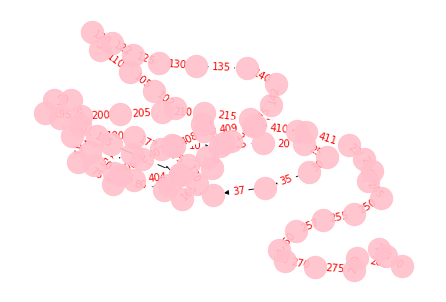

In [109]:
for route in route_graphs:
    route_graph = route_graphs[route]

    """
    for node in route_graph.nodes():
        route_graph.node[node]['label'] = node

    edge_labels = {}
    for node1, node2, data in route_graph.edges(data=True):
        edge_labels[(node1, node2)] = data['sequence_number'] 

    for edge in route_graph.edges():
        route_graph.edges[edge]['label'] = edge_labels[edge]

    # export as graphML file, see below
    nx.write_graphml(route_graph, "graph-111"+".graphml")
    """
    edge_labels = {}
    for node1, node2, data in route_graph.edges(data=True):

        edge_labels[(node1, node2)] = data['edge_data']['sequence_number']

    # draw directly from networkx
    pos = nx.spring_layout(route_graph)
    nx.draw(route_graph, pos, edge_color='black', width=1, linewidths=1, node_size=500, node_color='pink', alpha=0.9)
    nx.draw_networkx_edge_labels(route_graph,pos,edge_labels=edge_labels,font_color='red')
    plt.show()

### Find all admissible routes

In [110]:
paths = {}
for si in service_intentions:
    startnodes=[]
    endnodes = []
    G = route_graphs[si]
    for edge in G.edges(data=True):
        if 'start_end' in edge[2]['edge_data']:
            if edge[2]['edge_data']['start_end'] == 'start':
                startnodes.append(edge[0])
            if edge[2]['edge_data']['start_end'] == 'end':
                endnodes.append(edge[1])
    paths_si = []
    for s in startnodes:
        for e in endnodes:
            for path in nx.all_simple_paths(G, source=s, target=e):
                paths_si.append([(path[i], path[i+1]) for i in range(len(path)-1)])
    paths[si] = paths_si

In [111]:
si_list = []
t_index_by_edge = {}
delta_index_by_edge = {}
edges_by_path = {}
get_index_by_delta = {}
j=0
k=0
for si in paths:
    pathlist = []
    ttemp = {}
    dtemp = {}
    for i,path in enumerate(paths[si]):
        srlist = []
        etemp = {}
        for sr in path:
            srlist.append((si,i,sr))
            if sr in ttemp:
                ttemp[sr].append(j)
            else:
                ttemp[sr] = [j]
            
            
            if sr in dtemp:
                dtemp[sr].append(k)
            else:
                dtemp[sr] = [k]
            
            etemp[sr] = j
            if k in get_index_by_delta:
                get_index_by_delta[k].append(j)
            else:
                get_index_by_delta[k] = [j]
            j+=1
        edges_by_path[k] = etemp
            
        k+=1
        pathlist.append(srlist)
    t_index_by_edge[si] = ttemp
    delta_index_by_edge[si] = dtemp
    si_list.append(pathlist)

In [112]:
xindex = {}
enum = 0
for si in service_intentions:
    xindexsi = {}
    for i,e in enumerate(route_graphs[si].edges):
        xindexsi[e] = i+enum
    enum+=i+1
    xindex[si] = xindexsi

In [113]:
import itertools
betaindex = []
for (si1, si2) in list(itertools.combinations([key for key in service_intentions],2)):
    intsc = list(set.intersection(set(route_graphs[si1].edges), set(route_graphs[si2].edges)))
    for e in intsc:
        betaindex.append((si1, si2, e))

In [114]:
def recursive_len(item):
    if type(item) == list:
        return sum(recursive_len(subitem) for subitem in item)
    else:
        return 1

In [115]:
t_len = recursive_len(si_list)
x_len = 0
delta_len = 0
for si in service_intentions:
    x_len += len(route_graphs[si].edges)
    delta_len += len(paths[si])
beta_len = len(betaindex)
total_length = t_len*2 + x_len + delta_len + beta_len
total_length

1805

In [116]:
si_list

[[[(18823, 0, ('(1_beginning)', '(1->5)')),
   (18823, 0, ('(1->5)', '(5->10)')),
   (18823, 0, ('(5->10)', '(10->15)')),
   (18823, 0, ('(10->15)', '(15->20)')),
   (18823, 0, ('(15->20)', '(20->25)')),
   (18823, 0, ('(20->25)', '(25->30)')),
   (18823, 0, ('(25->30)', '(30->35)')),
   (18823, 0, ('(30->35)', '(35->37)')),
   (18823, 0, ('(35->37)', '(37->40)')),
   (18823, 0, ('(37->40)', '(40->45)')),
   (18823, 0, ('(40->45)', '(45->50)')),
   (18823, 0, ('(45->50)', '(50->52)')),
   (18823, 0, ('(50->52)', '(52->55)')),
   (18823, 0, ('(52->55)', '(55->60)')),
   (18823, 0, ('(55->60)', '(60->65)')),
   (18823, 0, ('(60->65)', '(65->70)')),
   (18823, 0, ('(65->70)', '(70->72)')),
   (18823, 0, ('(70->72)', '(72->75)')),
   (18823, 0, ('(72->75)', '(75->80)')),
   (18823, 0, ('(75->80)', '(80->85)')),
   (18823, 0, ('(80->85)', '(85->90)')),
   (18823, 0, ('(85->90)', '(90->95)')),
   (18823, 0, ('(90->95)', '(95->100)')),
   (18823, 0, ('(95->100)', '(100->102)')),
   (18823, 0,

### Variables

|t_in| = sum of the length of all service intentions, total number of paths per si and route sections per path  
|t_out| same as t_in  

|x| all service intentions and their route sections

|delta| all service intentions and their paths

$v = [t_{in}, t_{out} , x, \delta]$

#### Minimize objective function

$J(x)=\{ \frac{1}{60} \sum_{SI, R, RS} win_{rs}max(0, 
t_{si,r,rs}^{in} - LatIn_{si,rs}) + wout_{rs} max(0, t_{si,r,rs}^{out} - LatOut_{si,rs}) + p_{si,rs}x_{si,rs} \}$  



#### Subject to

time into a section comes before time out: 


(1)  $t_{si,r,rs}^{in} \leq t_{si,r,rs}^{out}$  

time into next section comes after time out from previous section:  
(2)  $t_{si,r,rs}^{out} \leq t_{si,r,rs+1}^{in}$

if r is the selected path, satisfy minimum running and stopping time:  
(3)  $t_{si,r,rs}^{out} - t_{si,r,rs}^{in} \geq mrt_{si, r, rs} + mst_{si, r, rs} - M(1-\delta_{si,r})$

Earliest in constraint:  
(4)  $t_{si,r,rs}^{in} \geq EarIn_{si,r,rs} - M(1-\delta_{si,r})$  

Earliest out constraint:  
(5)  $t_{si,r,rs}^{out} \geq EarOut_{si,r,rs} - M(1-\delta_{si,r})$

Select only one path to every service:  
(6)  $\sum_{r \in P} \delta_{si,r} = 1$  

All route sections on the chosen track are occupied  
(7)  $x_{si, re} \geq \delta_{si, r}$  

(8) $t_{si_1,r_1,re}^{in} - t_{si_2,r_2,re}^{in} \leq M(1-\beta_{si_1,si_2,re}) + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$  

(9) $t_{si_2,r_2,re}^{in} - t_{si_1,r_1,re}^{in} + \epsilon \leq M\beta_{si_1,si_2,re} + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

(10) $t_{si_1,r_1,re}^{out} - t_{si_2,r_2,re}^{in} + R \leq M(1-\beta_{si_1,si_2,re}) + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

(11) $t_{si_2,r_2,re}^{out} - t_{si_1,r_1,re}^{in} + R \leq M\beta_{si_1,si_2,re} + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

LatIn = entry_latest  
EarOut = exit_earliest  
EarIn = entry_earliest  
LatOut = exit_latest

In [117]:
from time import strftime
from time import gmtime

def str_to_sec(s):
    s=s.split(':')
    return int(s[0])*60*60+int(s[1])*60+int(s[2])
def sec_to_str(x):
    return strftime("%H:%M:%S", gmtime(x))

## Modelling approach

### Constraints

In [118]:
Mmrtmst = [1]
MEarOut = [1]
MEarIn = [1]
for si in route_graphs:
    for e in route_graphs[si].edges(data=True):
        edge_data = e[2]['edge_data']
        if ('exit_earliest' in edge_data):
            EarOut = str_to_sec(edge_data['exit_earliest'])
            MEarOut.append(EarOut)
        if ('entry_earliest' in edge_data):
            EarIn = str_to_sec(edge_data['entry_earliest'])
            MEarIn.append(EarIn)
        if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
            mst = 0
            mrt = 0
            if 'min_stopping_time' in edge_data:
                mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
            if 'minimum_running_time' in edge_data:
                mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds
            Mmrtmst.append(mrt+mst)

In [130]:
tin = cp.Variable(t_len, nonneg = True)
tout = cp.Variable(t_len, nonneg = True)
xs = cp.Variable(x_len,boolean = True)
deltas = cp.Variable(delta_len, boolean = True)
betas = cp.Variable(beta_len, boolean = True)
cs = []

#load (1)
i = 0
for si in si_list:
    for r in si:
        for rs in r:
            tcon = (tin[i] <= tout[i])
            cs.append(tcon)
            i+=1
#load (2)
i = 0
for si in si_list:
    for r in si:
        for j, rs in enumerate(r):
            if j!=len(r)-1:
                tcon = (tout[i] == tin[i+1])
                cs.append(tcon)
            i+=1
#load (3)
M=max(Mmrtmst)
i = 0
j = 0
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
                
                if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
                    mst = 0
                    mrt = 0
                    if 'min_stopping_time' in edge_data:
                        mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
                    if 'minimum_running_time' in edge_data:
                        mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds
                
                    tcon = (tout[i] - tin[i] >= mst+mrt - M*(1-deltas[j]))
                    cs.append(tcon)
                    
                i+=1
        j+=1
           
#load (4)
i = 0
j = 0
M=max(MEarIn)
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('entry_earliest' in edge_data):
                    EarIn = str_to_sec(edge_data['entry_earliest'])
                    tcon = (tin[i] >= EarIn - M*(1-deltas[j]))
                    cs.append(tcon)
                    
                i+=1
        j+=1
        

#load (5)
i = 0
j = 0
M=max(MEarOut)
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('exit_earliest' in edge_data):
                    EarOut = str_to_sec(edge_data['exit_earliest'])
                        
                    tcon = (tout[i] >= EarOut - M*(1-deltas[j]))
                    cs.append(tcon)
                        
                i+=1
        j+=1


#load (6)
j = 0
for si, si_id in zip(si_list, service_intentions):
    tempsum = 0
    for r in si:
        tempsum += deltas[j]
        j +=1
    tcon = (tempsum == 1)
    cs.append(tcon)
    
#load (7)
j=0
for si in paths:
    for path in paths[si]:
        for e in path:
            tcon = (xs[xindex[si][e]] >= deltas[j])
            cs.append(tcon)
    j+=1
    
#load (8)
i = 0
eps = 0
M = 10000
for (si1, si2, e) in betaindex:
    deltaidx1 = delta_index_by_edge[si1][e]
    deltaidx2 = delta_index_by_edge[si2][e]
    R1 = route_graphs[si1].edges[e]['edge_data']['R']
    R2 = route_graphs[si2].edges[e]['edge_data']['R']
    for idx1 in deltaidx1:
        for idx2 in deltaidx2:
            tcon = (tin[edges_by_path[idx1][e]] - tin[edges_by_path[idx2][e]] <= M*(1-betas[i]) + M*(2-deltas[idx1] - deltas[idx2]))
            cs.append(tcon)
            tcon = (tin[edges_by_path[idx2][e]] - tin[edges_by_path[idx1][e]] + eps <= M*betas[i] + M*(2-deltas[idx1] - deltas[idx2]))
            cs.append(tcon)
            tcon = (tout[edges_by_path[idx1][e]] - tin[edges_by_path[idx2][e]] + R2 <= M*(1-betas[i]) + M*(2-deltas[idx1] - deltas[idx2]))
            cs.append(tcon)
            tcon = (tout[edges_by_path[idx2][e]] - tin[edges_by_path[idx1][e]] + R1 <= M*betas[i] + M*(2-deltas[idx1] - deltas[idx2]))
            cs.append(tcon)
    

(8) $t_{si_1,r_1,re}^{in} - t_{si_2,r_2,re}^{in} \leq M(1-\beta_{si_1,si_2,re}) + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$  

(9) $t_{si_2,r_2,re}^{in} - t_{si_1,r_1,re}^{in} + \epsilon \leq M\beta_{si_1,si_2,re} + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

(10) $t_{si_1,r_1,re}^{out} - t_{si_2,r_2,re}^{in} + R \leq M(1-\beta_{si_1,si_2,re}) + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

(11) $t_{si_2,r_2,re}^{out} - t_{si_1,r_1,re}^{in} + R \leq M\beta_{si_1,si_2,re} + M(2- \delta_{si_1,r_1} - \delta_{si_2,r_2})$

### Objective function

In [131]:
objective = 0
i = 0
j=0
M2 = 100000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
            edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            if 'entry_delay_weight' in edge_data and 'entry_latest' in edge_data:
                objective += float(edge_data['entry_delay_weight'])*cp.maximum(0, tin[i]-str_to_sec(edge_data['entry_latest'])) #, M*(1-deltas[j]))
            if 'exit_delay_weight' in edge_data and 'exit_latest' in edge_data:
                objective += float(edge_data['exit_delay_weight'])*cp.maximum(0, tout[i]-str_to_sec(edge_data['exit_latest'])) #,M*(1-deltas[j]))  
            i+=1
        j+=1
objective /=60
i = 0
j=0
for si, si_id in zip(si_list, service_intentions):
    for edge in route_graphs[si_id].edges(data=True):
        e = (edge[0],edge[1])
        p = 0
        if 'penalty' in edge[2]['edge_data']:
            p = edge[2]['edge_data']['penalty']
            if p == None:
                p = 0
            else:
                p = float(p)
            objective += xs[xindex[si_id][e]]*p
        i+=1

In [132]:
objective

Expression(CONVEX, NONNEGATIVE, ())

### Solver

In [133]:
prob = cp.Problem(cp.Minimize(objective),
                 cs)
prob.solve(solver = 'MOSEK', verbose = True)

                                     CVXPY                                     
                                    v1.1.14                                    
(CVXPY) Aug 13 09:47:09 AM: Your problem has 1805 variables, 6970 constraints, and 0 parameters.
(CVXPY) Aug 13 09:47:10 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 13 09:47:10 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 13 09:47:10 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 13 09:47:11 AM: Compiling problem (target solver=MOSEK).
(CVXPY) Aug 13 09:47:11 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuff

49.08333333333352

In [134]:
deltas = deltas.value
tin = tin.value
tout = tout.value
xs = xs.value
betas = betas.value

### Constraint check

In [135]:
cs=[]

#load (1)
i = 0
for si in si_list:
    for r in si:
        for rs in r:
            tcon = (tin[i] <= tout[i])
            cs.append(tcon)
            i+=1
#load (2)
i = 0
for si in si_list:
    for r in si:
        for j, rs in enumerate(r):
            if j!=len(r)-1:
                tcon = (tout[i] == tin[i+1])
                cs.append(tcon)
            i+=1
#load (3)
M=max(Mmrtmst)
i = 0
j = 0
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
                
                if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
                    mst = 0
                    mrt = 0
                    if 'min_stopping_time' in edge_data:
                        mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
                    if 'minimum_running_time' in edge_data:
                        mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds
                
                    tcon = (tout[i] - tin[i] >= mst+mrt - M*(1-deltas[j]))
                    cs.append(tcon)
                    
                i+=1
        j+=1
           
#load (4)
i = 0
j = 0
M=max(MEarIn)
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('entry_earliest' in edge_data):
                    EarIn = str_to_sec(edge_data['entry_earliest'])
                    tcon = (tin[i] >= EarIn - M*(1-deltas[j]))
                    cs.append(tcon)
                    
                i+=1
        j+=1
        

#load (5)
i = 0
j = 0
M=max(MEarOut)
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('exit_earliest' in edge_data):
                    EarOut = str_to_sec(edge_data['exit_earliest'])
                        
                    tcon = (tout[i] >= EarOut - M*(1-deltas[j]))
                    cs.append(tcon)
                        
                i+=1
        j+=1


#load (6)
j = 0
for si, si_id in zip(si_list, service_intentions):
    tempsum = 0
    for r in si:
        tempsum += deltas[j]
        j +=1
    tcon = (tempsum == 1)
    cs.append(tcon)
    
#load (7)
j=0
for si in paths:
    for path in paths[si]:
        for e in path:
            tcon = (xs[xindex[si][e]] >= deltas[j])
            cs.append(tcon)
    j+=1
    
#load (8)
i = 0
eps = 0
M = 10000
for (si1, si2, e) in betaindex:
    deltaidx1 = delta_index_by_edge[si1][e]
    deltaidx2 = delta_index_by_edge[si2][e]
    R1 = route_graphs[si1].edges[e]['edge_data']['R']
    R2 = route_graphs[si2].edges[e]['edge_data']['R']
    for idx1 in deltaidx1:
        for idx2 in deltaidx2:
            tcon = (tin[edges_by_path[idx1][e]] - tin[edges_by_path[idx2][e]] <= M*(1-betas[i]) + M*(2-deltas[idx1] - deltas[idx2]))
            cs.append(tcon)
            tcon = (tin[edges_by_path[idx2][e]] - tin[edges_by_path[idx1][e]] + eps <= M*betas[i] + M*(2-deltas[idx1] - deltas[idx2]))
            cs.append(tcon)
            tcon = (tout[edges_by_path[idx1][e]] - tin[edges_by_path[idx2][e]] + R2 <= M*(1-betas[i]) + M*(2-deltas[idx1] - deltas[idx2]))
            cs.append(tcon)
            tcon = (tout[edges_by_path[idx2][e]] - tin[edges_by_path[idx1][e]] + R1 <= M*betas[i] + M*(2-deltas[idx1] - deltas[idx2]))
            cs.append(tcon)
    

print('constraints check?')
for i,b in enumerate(cs):
    if b == False:
        print(i, 'is false')

constraints check?
1294 is false
2776 is false
2912 is false
4389 is false


In [136]:
ad_paths = np.where(deltas==1)[0]

In [137]:
paths_flat = []
timetable = {}
for si in paths:
    paths_flat += paths[si]
for (si,ad_path) in zip(service_intentions, ad_paths):
    p = paths_flat[ad_path]
    timetable[si] = {'tin': [], 'tout':[]}
    for idx,e in zip(get_index_by_delta[ad_path],p):
        timetable[si]['tin'].append((tin[idx]))
        timetable[si]['tout'].append((tout[idx]))
        
        print(f'si: {si}, edge: {e}, tin: {sec_to_str(tin[idx])}, tout: {sec_to_str(tout[idx])}')
        #print(route_graphs[si].edges[e])
        

si: 18823, edge: ('(1_beginning)', '(1->5)'), tin: 06:35:00, tout: 06:37:00
si: 18823, edge: ('(1->5)', '(5->10)'), tin: 06:37:00, tout: 06:37:32
si: 18823, edge: ('(5->10)', '(10->15)'), tin: 06:37:32, tout: 06:37:40
si: 18823, edge: ('(10->15)', '(15->20)'), tin: 06:37:40, tout: 06:37:54
si: 18823, edge: ('(15->20)', '(20->25)'), tin: 06:37:54, tout: 06:38:14
si: 18823, edge: ('(20->25)', '(25->30)'), tin: 06:38:14, tout: 06:38:34
si: 18823, edge: ('(25->30)', '(30->35)'), tin: 06:38:34, tout: 06:38:45
si: 18823, edge: ('(30->35)', '(35->37)'), tin: 06:38:45, tout: 06:38:59
si: 18823, edge: ('(35->37)', '(37->40)'), tin: 06:38:59, tout: 06:39:33
si: 18823, edge: ('(37->40)', '(40->45)'), tin: 06:39:33, tout: 06:40:17
si: 18823, edge: ('(40->45)', '(45->50)'), tin: 06:40:17, tout: 06:40:37
si: 18823, edge: ('(45->50)', '(50->52)'), tin: 06:40:37, tout: 06:42:26
si: 18823, edge: ('(50->52)', '(52->55)'), tin: 06:42:26, tout: 06:43:00
si: 18823, edge: ('(52->55)', '(55->60)'), tin: 06:4

In [25]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize = (20,15))
s=100
for si in timetable:
    plt.scatter(range(len(timetable[si]['tin'])),timetable[si]['tin'], marker = 'o', label = si, s=s)
    plt.scatter(range(1,len(timetable[si]['tout'])+1),timetable[si]['tout'], marker = 'x', label = si, s=s)
plt.legend()

## Appendix

### Matrix approach

In [ ]:

A = np.array([])
b = []

#load (1)
i = 0
for si in si_list:
    for r in si:
        for rs in r:
            temp = np.zeros(total_length)
            temp[i] = 1 #tin
            temp[i+t_len] = -1 #tout
            b.append(0)
            i+=1
            if len(A)==0:
                A = temp
            else:
                A = np.vstack((A,temp))
#load (2)
i = 0
for si in si_list:
    for r in si:
        for j, rs in enumerate(r):
            if j!=len(r)-1:
                temp = np.zeros(total_length)
                temp[i+1] = -1 #tin
                temp[i+t_len] = 1 #tout
                b.append(0)

                if len(A)==0:
                    A = temp
                else:
                    A = np.vstack((A,temp))
            i+=1

#load (3)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('min_stopping_time' in edge_data) or ('minimum_running_time' in edge_data):
                    mst = 0
                    mrt = 0
                    if 'min_stopping_time' in edge_data:
                        mst = isodate.parse_duration(edge_data['min_stopping_time']).seconds
                    if 'minimum_running_time' in edge_data:
                        mrt = isodate.parse_duration(edge_data['minimum_running_time']).seconds
                
                    temp = np.zeros(total_length)
                    temp[i] = 1 #tin
                    temp[i+t_len+1] = -1 #tout
                    temp[j+t_len+t_len+x_len] = M
                    b.append(M-mst-mrt)
                    
                    if len(A)==0:
                        A = temp
                    else:
                        A = np.vstack((A,temp))
                i+=1
        j+=1
        
print(j)        
#load (4)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('entry_earliest' in edge_data):
                    EarIn = str_to_sec(edge_data['entry_earliest'])
                        
                    temp = np.zeros(total_length)
                    temp[i] = -1 #tin
                    temp[j+t_len+t_len+x_len] = M
                    b.append(M-EarIn)
                    if len(A)==0:
                        A = temp
                    else:
                        A = np.vstack((A,temp))
                i+=1
        j+=1
        

#load (5)
i = 0
j = 0
M = 1000000
for si, si_id in zip(si_list, service_intentions):
    for r in si:
        for rs in r:
                edge_data = route_graphs[si_id].edges[rs[2]]['edge_data']
            
                if ('exit_earliest' in edge_data):
                    EarOut = str_to_sec(edge_data['exit_earliest'])
                        
                    temp = np.zeros(total_length)
                    temp[i + t_len] = -1 #tin
                    temp[j+t_len+t_len+x_len] = M
                    b.append(M-EarOut)
                    if len(A)==0:
                        A = temp
                    else:
                        A = np.vstack((A,temp))
                i+=1
        j+=1
b = np.array(b).astype('float64')
c = np.array([1.0]*total_length)